### x lines of Python

# Reading and writing LAS files

This notebook goes with [the Agile blog post](https://agilescientific.com/blog/2017/10/23/x-lines-of-python-load-curves-from-las) of 23 October.

Set up a `conda` environment with:

    conda create -n welly python=3.6 matplotlib=2.0 scipy pandas

You'll need `welly` in your environment:

    conda install tqdm  # Should happen automatically but doesn't
    pip install welly
    
This will also install the latest versions of `striplog` and `lasio`.

In [1]:
import welly

In [14]:
ls logs/*.las

logs/F02-01_F02-01_Set.las     logs/F03-06_F03-06_Set.las
logs/F03-03_F03-03_Set.las     logs/F06-01_F06-01_Set.las
logs/F03-04_F03-04_Set.las     logs/F06-02_F06-02_Set.las
logs/F03-05_F03-05-S1_Set.las


### 1. Load the LAS file with `lasio`

In [21]:
import lasio

l = lasio.read('logs/F02-01_F02-01_Set.las')


Header section Parameter regexp=~P was not found.


That's it! But the object itself doesn't tell us much — it's really just a container:

In [22]:
l

### 2. Look at the WELL section of the header

In [23]:
l.header['Well']  # Line 2.

[HeaderItem(mnemonic=STRT, unit=m, value=48.2001, descr=START DEPTH),
 HeaderItem(mnemonic=STEP, unit=m, value=0.0, descr=STEP DEPTH),
 HeaderItem(mnemonic=STOP, unit=m, value=3124.0, descr=STOP DEPTH),
 HeaderItem(mnemonic=NULL, unit=, value=-999.25, descr=NULL VALUE),
 HeaderItem(mnemonic=COMP, unit=, value=, descr=COMPANY),
 HeaderItem(mnemonic=WELL, unit=, value=F02-01, descr=WELL),
 HeaderItem(mnemonic=LOC, unit=, value=, descr=LOCATION - AREA),
 HeaderItem(mnemonic=FLD, unit=, value=, descr=FIELD),
 HeaderItem(mnemonic=CTRY, unit=, value=, descr=COUNTRY),
 HeaderItem(mnemonic=DATE, unit=, value=, descr=WELL DATE),
 HeaderItem(mnemonic=XWELL, unit=m, value=606549.0, descr=X POS),
 HeaderItem(mnemonic=YWELL, unit=m, value=6080124.0, descr=Y POS)]

You can go in and find the KB if you know what to look for:

In [29]:
l.header.keys()

dict_keys(['Version', 'Well', 'Curves', 'Parameter', 'Other'])

In [32]:
l.header['Curves']

[CurveItem(mnemonic=DEPT, unit=Meter, value=, descr=1, original_mnemonic=DEPT, data.shape=(30759,)),
 CurveItem(mnemonic=NPHI, unit=V/V, value=, descr=2, original_mnemonic=NPHI, data.shape=(30759,)),
 CurveItem(mnemonic=DRHO, unit=G/C3, value=, descr=3, original_mnemonic=DRHO, data.shape=(30759,)),
 CurveItem(mnemonic=GR, unit=GAPI, value=, descr=4, original_mnemonic=GR, data.shape=(30759,)),
 CurveItem(mnemonic=RHOB, unit=G/C3, value=, descr=5, original_mnemonic=RHOB, data.shape=(30759,)),
 CurveItem(mnemonic=DT, unit=US/F, value=, descr=6, original_mnemonic=DT, data.shape=(30759,))]

### 3. Look at the curve data

The curves are all present one big NumPy array:

In [33]:
l.data

array([[4.8200100e+01,           nan,           nan,           nan,
                  nan,           nan],
       [4.8300100e+01,           nan,           nan,           nan,
                  nan,           nan],
       [4.8400100e+01,           nan,           nan,           nan,
                  nan,           nan],
       ...,
       [3.1238000e+03, 3.0523000e-01, 8.6490000e-02, 1.0597838e+02,
        2.4666600e+00,           nan],
       [3.1239000e+03, 3.0935000e-01, 8.8220000e-02, 9.9514160e+01,
        2.4526100e+00,           nan],
       [3.1240000e+03,           nan,           nan, 8.7476690e+01,
                  nan,           nan]])

Or we can go after a single curve object:

In [34]:
l.curves.GR  # Line 3.

CurveItem(mnemonic=GR, unit=GAPI, value=, descr=4, original_mnemonic=GR, data.shape=(30759,))

And there's a shortcut to its data:

In [35]:
l['GR']  # Line 4.

array([      nan,       nan,       nan, ..., 105.97838,  99.51416,
        87.47669])

...so it's easy to make a plot against depth:

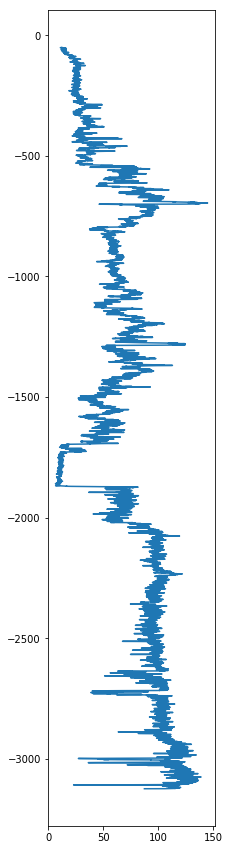

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(3,15))
plt.plot(l['GR'], -l['DEPT'])
plt.show()

### 4. Inspect the curves as a `pandas` dataframe

In [49]:
l.df().head()  # Line 5.

,NPHI,DRHO,GR,RHOB,DT
DEPT,,,,,
48.2001,NaN,NaN,NaN,NaN,NaN
48.3001,NaN,NaN,NaN,NaN,NaN
48.4001,NaN,NaN,NaN,NaN,NaN
48.5001,NaN,NaN,NaN,NaN,NaN
48.6001,NaN,NaN,NaN,NaN,NaN


### 5. Load the LAS file with `welly` 

In [41]:
from welly import Well

w = Well.from_las('logs/F02-01_F02-01_Set.las')  # Line 6.

Header section Parameter regexp=~P was not found.


`welly` Wells know how to display some basics:

In [42]:
w

Well(uwi: '', 5 curves: ['NPHI', 'DRHO', 'GR', 'RHOB', 'DT'])

And the `Well` object also has `lasio`'s access to a pandas DataFrame:

In [79]:
wdf = w.df()
wdf['AI'] = w.df()['RHOB']*w.df()['DT']
wdf.head()

,NPHI,DRHO,GR,RHOB,DT,AI
DEPT,,,,,,
48.2001,NaN,NaN,NaN,NaN,NaN,NaN
48.3001,NaN,NaN,NaN,NaN,NaN,NaN
48.4001,NaN,NaN,NaN,NaN,NaN,NaN
48.5001,NaN,NaN,NaN,NaN,NaN,NaN
48.6001,NaN,NaN,NaN,NaN,NaN,NaN


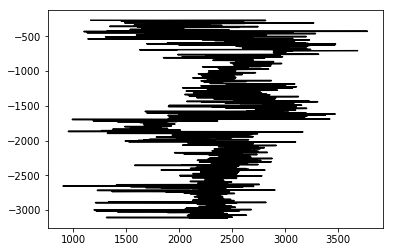

In [96]:
import bruges
import numpy as np
import matplotlib.pyplot as plt

w = bruges.filters.ricker(duration=0.1, dt=0.001, f=10)
synth = np.convolve(wdf['AI'],w, mode='same')

plt.plot(synth,-wdf.index.values, c='k')

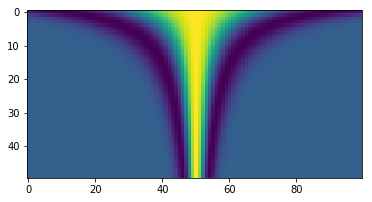

In [97]:
import bruges
import numpy as np
import matplotlib.pyplot as plt

w = bruges.filters.ricker(duration=0.1, dt=0.001, f=np.linspace(10,100))
# synth = np.convolve(wdf['AI'],w, mode='same')
plt.imshow(w)
# plt.plot(synth,-wdf.index.values, c='k')

### 6. Look at `welly`'s Curve object

Like the `Well`, a `Curve` object can report a bit about itself:

In [72]:
GR = w.data['GR']  # Line 7.
gr

Curve([         nan,          nan,          nan, ..., 107.81260399,
       105.97191596,  99.50212287])

One important thing about Curves is that each one knows its own depths — they are stored as a property called `basis`. (It's not actually stored, but computed on demand from the start depth, the sample interval (which must be constant for the whole curve) and the number of samples in the object.)

In [54]:
gr.basis

array([  48.2001,   48.3001,   48.4001, ..., 3123.7001, 3123.8001,
       3123.9001])

### 7. Plot part of a curve

We'll grab the interval from 300 m to 1000 m and plot it.

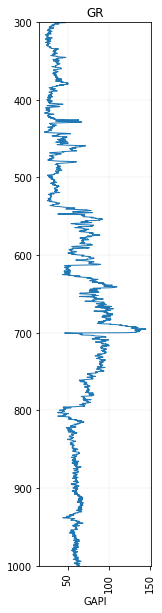

In [55]:
gr.to_basis(start=300, stop=1000).plot()  # Line 8.

### 8. Smooth a curve

Curve objects are, fundamentally, NumPy arrays. But they have some extra tricks. We've already seen `Curve.plot()`. 

Using the `Curve.smooth()` method, we can easily smooth a curve, eg by 15 m (passing `samples=True` would smooth by 15 samples):

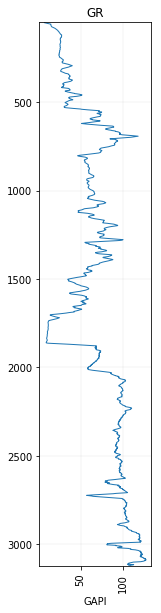

In [56]:
sm = gr.smooth(window_length=15, samples=False)  # Line 9.

sm.plot()

### 9. Export a set of curves as a matrix

You can get at all the data through the lasio `l.data` object:

In [57]:
print("Data shape: {}".format(w.las.data.shape))

w.las.data

Data shape: (30759, 6)


array([[4.8200100e+01,           nan,           nan,           nan,
                  nan,           nan],
       [4.8300100e+01,           nan,           nan,           nan,
                  nan,           nan],
       [4.8400100e+01,           nan,           nan,           nan,
                  nan,           nan],
       ...,
       [3.1238000e+03, 3.0523000e-01, 8.6490000e-02, 1.0597838e+02,
        2.4666600e+00,           nan],
       [3.1239000e+03, 3.0935000e-01, 8.8220000e-02, 9.9514160e+01,
        2.4526100e+00,           nan],
       [3.1240000e+03,           nan,           nan, 8.7476690e+01,
                  nan,           nan]])

But we might want to do some other things, such as specify which curves you want (optionally using aliases like GR1, GRC, NGC, etc for GR), resample the data, or specify a start and stop depth — `welly` can do all this stuff. This method is also wrapped by `Project.data_as_matrix()` which is nice because it ensures that all the wells are exported at the same sample interval.

Here are the curves in this well:

In [76]:
w.data.keys()

dict_keys(['NPHI', 'DRHO', 'GR', 'RHOB', 'DT'])

In [77]:
keys=['CALI', 'DT', 'DTS', 'RHOB', 'SP']

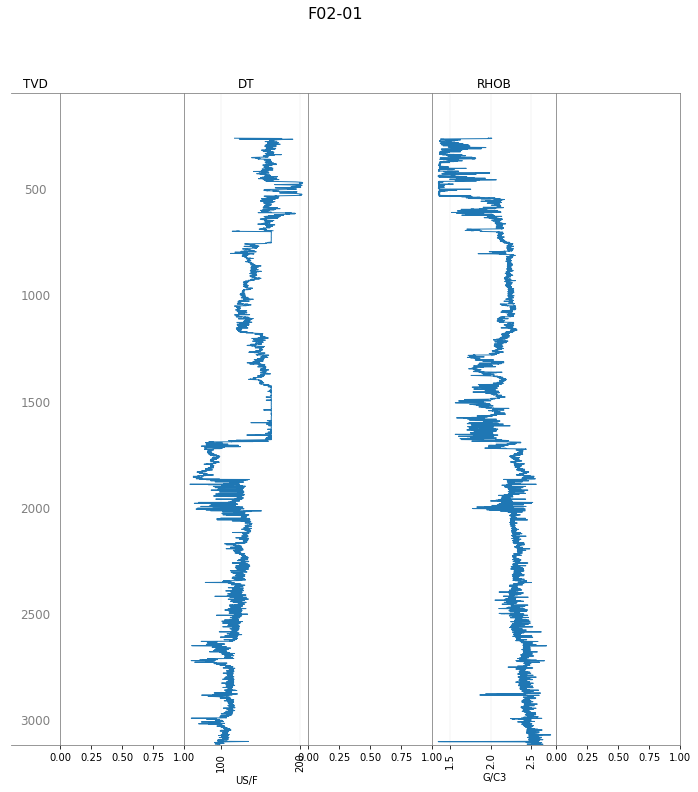

In [60]:
w.plot(tracks=['TVD']+keys)

In [23]:
X, basis = w.data_as_matrix(keys=keys, start=275, stop=1850, step=0.5, return_basis=True)

In [24]:
w.data['CALI'].shape

(12718,)

So CALI had 12,718 points in it... since we downsampled to 0.5 m and removed the top and tail, we should have substantially fewer points:

In [25]:
X.shape

(3151, 5)

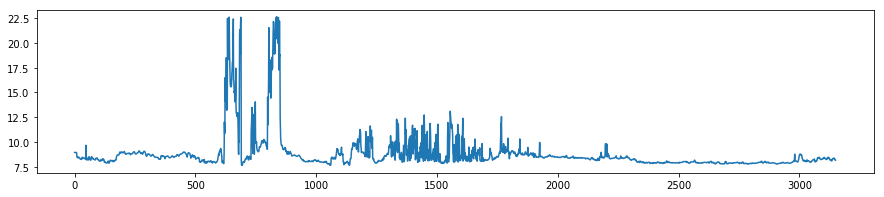

In [26]:
plt.figure(figsize=(15,3))
plt.plot(X.T[0])
plt.show()

### 10+. BONUS: fix the lat, lon

OK, we're definitely going to go over our budget on this one.

Did you notice that the location of the well did not get loaded properly?

In [27]:
w.location

Location({'td': 1935.0, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'kb': 94.8, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'deviation': None, 'position': None})

Let's look at some of the header:

    # LAS format log file from PETREL
    # Project units are specified as depth units
    #==================================================================
    ~Version information
    VERS.   2.0:
    WRAP.   YES:
    #==================================================================
    ~WELL INFORMATION
    #MNEM.UNIT      DATA             DESCRIPTION
    #---- ------ --------------   -----------------------------
    STRT .M      1.0668          :START DEPTH     
    STOP .M      1939.13760      :STOP DEPTH     
    STEP .M       0.15240        :STEP        
    NULL .          -999.25      :NULL VALUE
    COMP .        Elmworth Energy Corporation              :COMPANY
    WELL .        Kennetcook #2                            :WELL
    FLD  .        Windsor Block                            :FIELD
    LOC  .        Lat = 45* 12' 34.237" N                  :LOCATION
    PROV .        Nova Scotia                              :PROVINCE
      UWI.        Long = 63* 45'24.460  W                  :UNIQUE WELL ID
    LIC  .        P-129                                    :LICENSE NUMBER
    CTRY .        CA                                       :COUNTRY (WWW code)
     DATE.        10-Oct-2007                              :LOG DATE {DD-MMM-YYYY}
    SRVC .        Schlumberger                             :SERVICE COMPANY
    LATI .DEG                                              :LATITUDE
    LONG .DEG                                              :LONGITUDE
    GDAT .                                                 :GeoDetic Datum
    SECT .        45.20 Deg N                              :Section
    RANG .        PD 176                                   :Range
    TOWN .        63.75 Deg W                              :Township

Look at **LOC** and **UWI**. There are two problems:

1. These items are in the wrong place. (Notice **LATI** and **LONG** are empty.)
2. The items are malformed, with lots of extraneous characters.

We can fix this in two steps:

1. Remap the header items to fix the first problem.
2. Parse the items to fix the second one.

We'll define these in reverse because the remapping uses the transforming function.

In [28]:
import re

def transform_ll(text):
    """
    Parses malformed lat and lon so they load properly.
    """
    def callback(match):
        d = match.group(1).strip()
        m = match.group(2).strip()
        s = match.group(3).strip()
        c = match.group(4).strip()
        if c.lower() in ('w', 's') and d[0] != '-':
            d = '-' + d
        return ' '.join([d, m, s])
    pattern = re.compile(r""".+?([-0-9]+?).? ?([0-9]+?).? ?([\.0-9]+?).? +?([NESW])""", re.I)
    text = pattern.sub(callback, text)
    return welly.utils.dms2dd([float(i) for i in text.split()])

Make sure that works!

In [29]:
print(transform_ll("""Lat = 45* 12' 34.237" N"""))

45.20951027777778


In [30]:
remap = {
    'LATI': 'LOC',  # Use LOC for the parameter LATI.
    'LONG': 'UWI',  # Use UWI for the parameter LONG.
    'LOC':  None,   # Use nothing for the parameter SECT.
    'SECT': None,   # Use nothing for the parameter SECT.
    'RANG': None,   # Use nothing for the parameter RANG.
    'TOWN': None,   # Use nothing for the parameter TOWN.
}

funcs = {
    'LATI': transform_ll,  # Pass LATI through this function before loading.
    'LONG': transform_ll,  # Pass LONG through it too.
    'UWI': lambda x: "No UWI, fix this!"
}

In [31]:
w = Well.from_las('../data/P-129.LAS', remap=remap, funcs=funcs)

In [32]:
w.location.latitude, w.location.longitude

(45.20951027777778, -62.243205555555555)

In [33]:
w.uwi

'No UWI, fix this!'

Let's just hope the mess is the same mess in every well. (LOL, no-one's that lucky.)

<hr>

**&copy; 2017 [agilescientific.com](https://www.agilescientific.com/) and licensed [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)**